### GIADA BARZAGHI - OCTOBER 2021
## MODEL 2: ITINERARIES AND FIXED DEMAND
#### OPTIMIZING AVIATION NETWORKS TO MINIMIZE POLLUTION 

In [80]:
# GIADA BARZAGHI - SEPTEMBER 2021
# MODEL 2: WITH ITINERARIES AND FIXED DEMAND

# SETTING UP WORKING ENVIRONMENT 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pyomo.environ import *
import string
import math as math
import random
import itertools
import geopandas # on terminal: conda activate geo_env ---- jupyter notebook if not launching from anaconda navigator 
from shapely.geometry import Point, Polygon
import geopy
from geopy.distance import great_circle

# PRE PROCESSING

# Inserting some real-world data 

TO DOs: 
- DONE: Great circle distance NOT cartesian -> basato su latitudini e longitudini 
- DONE: calcola pollution in CO2: fuel from seymour (regressione con distanza in great circle distance) x fattore di conversione indicato da Seymour (3.16) --> cambia la p nei dati 
- DONE: lat e long da https://openflights.org/data.html (lat e long fornite per ogni aeroporto) - Seymour gets data from Planespotters.net
- DONE: itinreari + flights generati da una lista di lettere i.e. crea in automatico l'insieme i (fai prima insieme con trattino e poi quelli senza trattino, poi li sommi in un unico insieme) e l'insieme f (lista di tuple) da una lista di lettere --> tutte le coppie possibili con rispettivi itinerari 


### REAL-WORLD DATA ON LATITUDE AND LONGITUDE 

Selecting some European airports from  https://openflights.org/data.html with related data on latitude and longitude 
- Milano Malpensa: MXP, lat: 45.6306, long: 8.72811
- Amsterdam Schiphol: AMS, lat: 52.308601, long: 4.76389
- Budapest: BUD, lat: 47.42976, long: 19.261093
- Athen Helenikon Airport: HEW, lat: 37.893299, long: 23.726101 

In [81]:
# creating a small sample dataframe of Europena airports 
DF = pd.DataFrame(
    {'City': ['Milano Malpensa', 'Amsterdam Schiphol', 'Budapest', 'Athen Helenikon'],
    'IATA code':['MXP', 'AMS', 'BUD', 'HEW'], 
    'Latitude': ['45.6306', '52.308601', '47.42976', '37.893299'], 
    'Longitude': ['8.72811', '4.76389', '19.261093', '23.726101']})
DF.head()

,City,IATA code,Latitude,Longitude
0,Milano Malpensa,MXP,45.6306,8.72811
1,Amsterdam Schiphol,AMS,52.308601,4.76389
2,Budapest,BUD,47.42976,19.261093
3,Athen Helenikon,HEW,37.893299,23.726101


### GEOGRAPHIC REPRESENTATION

<AxesSubplot:>

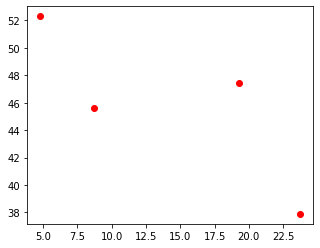

In [82]:
# creating the geopandas dataframe 
gdf = geopandas.GeoDataFrame(
    DF, geometry=geopandas.points_from_xy(DF.Longitude, DF.Latitude))
gdf.head()
gdf.plot(color='red')

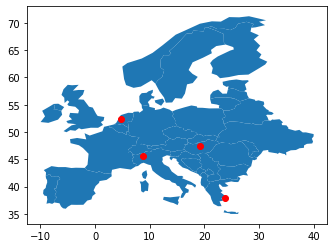

In [83]:
# plotting the coordinates on a map 
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# We restrict to Europe.
eu = world[world.continent == 'Europe']

#Remove Russia and Iceland from map of Europe
eu=eu[(eu.name!='Russia') & (eu.name!='Iceland')]
#eu.plot()

# Create a custom polygon to remove French Guinea from map
polygon = Polygon([(-25,35), (40,35), (40,75),(-25,75)])
poly_gdf = geopandas.GeoDataFrame([1], geometry=[polygon], crs=world.crs)

#Clip polygon from the map of Europe
europe=geopandas.clip(eu, polygon) 

fig,ax=plt.subplots()
ax=europe.plot(ax=ax)

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, color='red')

plt.show()

# !!!!! points are a bit out of place 

### GREAT CIRCLE DISTANCE BETWEEN AIRPORTS

In [84]:
import math

def distance_on_unit_sphere(start, end):
    lat1 = float(start[0])
    long1 = float(start[1])
    lat2= float(end[0])
    long2 = float(end[1])

    # Convert latitude and longitude to 
    # spherical coordinates in radians.
    degrees_to_radians = math.pi/180.0
        
    # phi = 90 - latitude
    phi1 = (90.0 - lat1)*degrees_to_radians
    phi2 = (90.0 - lat2)*degrees_to_radians
        
    # theta = longitude
    theta1 = long1*degrees_to_radians
    theta2 = long2*degrees_to_radians
        
    # Compute spherical distance from spherical coordinates.
        
    # For two locations in spherical coordinates 
    # (1, theta, phi) and (1, theta, phi)
    # cosine( arc length ) = 
    #    sin phi sin phi' cos(theta-theta') + cos phi cos phi'
    # distance = rho * arc length
    
    cos = (math.sin(phi1)*math.sin(phi2)*math.cos(theta1 - theta2) + 
           math.cos(phi1)*math.cos(phi2))
    arc = math.acos( cos )
    # Remember to multiply arc by the radius of the earth 
    # in your favorite set of units to get length.
    distance = arc*6378 #equatorial radius in km 

   
    return distance

# NOTE: THIS FUNCTION RETURNS VALUES THAT ARE IN BETWEEN 0-1 UNITS LARGER THAN THOSE RETURNED BY geopy.great_circle

In [85]:
# creating latlon column in dataframe
DF['latlon'] = list(zip(DF['Latitude'], DF['Longitude']))

# creating an empty squared df to populate with distances later (initiate with zeroes)
square = pd.DataFrame(
    np.zeros((DF.shape[0], DF.shape[0])),
    index=DF.index, columns=DF.index
)

# defining the distance function: returns distance between a point and all the others in the network 
def get_distance(col):
    end = DF.loc[col.name, 'latlon']
    return DF['latlon'].apply(distance_on_unit_sphere,
                              args=(end,)
                             )

distances = square.apply(get_distance, axis=1).T
distances = distances.rename(columns={0: 'MXP',1:'AMS', 2:'BUD', 3:'HEW'}, index={0: 'MXP',1:'AMS', 2:'BUD', 3:'HEW'})
distances

,MXP,AMS,BUD,HEW
MXP,0.000000,797.517773,830.418336,1510.213851
AMS,797.517773,0.000000,1170.496193,2176.567773
BUD,830.418336,1170.496193,0.000000,1122.229051
HEW,1510.213851,2176.567773,1122.229051,0.000000


### SETS OF AIRPORTS, MARKETS, FLIGHT LEGS AND ITINERARIES

In [95]:
# 1: CREATING THE LIST OF AIRPORTS USING IATA CODES
Airports = DF['IATA code']

# 2: GENERATING ALL POSSIBLE COMBINATIONS OF AIRPORTS TO OBTAIN FLIGHT LEGS
F = list(itertools.combinations(Airports, 2))
print(F)

# 2.1: FOR NOW ASSUMING THAT EACH MARKET IS EQUIVALENT TO AIRPORT-PAIRS (RATHER THAN CITY-PAIRS)
# CREATING SET OF MARKETS
M = F 

# 3: GENERATING ALL POSSIBLE ITINERARIES :

# CREATING A FUNCTION THAT GENERATES ALL POSSIBLE ITINERARIES FROM A LIST OF FLIGHT LEGS (TAKES F AS INPUT) 
def create_itineraries(F):
#set of non stop itineraries
    non_stop = [] 
    for f in F: 
        i = (f[0], '-', f[1])
        non_stop.append(i)

# set of one-stop itineraries 
    F1 = F
    one_stop = []
    for f in F: 
        for t in F1:
             if f[1]==t[0]:
                i = (f[0], f[1], t[1])
                one_stop.append(i)
   
#set of all itineraries 
    I = non_stop + one_stop
    #print(I)
    return I

# APPLYING THE FUNCTION
I = create_itineraries(F)

[('MXP', 'AMS'), ('MXP', 'BUD'), ('MXP', 'HEW'), ('AMS', 'BUD'), ('AMS', 'HEW'), ('BUD', 'HEW')]


### POLLUTION FOR EACH FLIGHT-LEG


#### Fuel consumption regressions for chosen aircraft models: (Appendix Table M.7) Seymour et al. 2020
- E170: F = 7.15e−5d^2gc + 1.79dgc + 746
- A319: F = 7.70e−5d^2gc + 2.32dgc + 1280
- A321: F = −5.88e−5d^2gc + 4.09dgc + 1182

then multiply by 3.16 (0r 3.10) to get CO2 emissions 3.16kg CO2/kg fuel burnt

In [98]:
# set of aircraft models
A = ['E170', 'A319', 'A321']

# Dictionary with pollution values for each flight-leg when operated by a specific aircraft type
P = {} 
for flight_leg in F: 
    for aircraft in A: 
        dist = distances[flight_leg[0]][flight_leg[1]] 
        if aircraft == 'E170':
            P[flight_leg, aircraft] = ((dist**2)*7.15e-7+dist*1.79+746)*3.16 # multiply by correction factor 3.16 to get pollution in CO2
        elif aircraft =='A319':
            P[flight_leg, aircraft] = ((dist**2)*7.70e-5+dist*2.32+1280)*3.16
        else:
            P[flight_leg, aircraft] = ((dist**2)*(-5.88e-5)+dist*4.09+1182)*3.16
P 
    

{(('MXP', 'AMS'), 'E170'): 6869.87658645332,
 (('MXP', 'AMS'), 'A319'): 10046.322234070334,
 (('MXP', 'AMS'), 'A321'): 13924.378385795131,
 (('MXP', 'BUD'), 'E170'): 7056.096347051408,
 (('MXP', 'BUD'), 'A319'): 10300.55506774613,
 (('MXP', 'BUD'), 'A321'): 14339.646548737806,
 (('MXP', 'HEW'), 'E170'): 10904.886742349643,
 (('MXP', 'HEW'), 'A319'): 15671.430868548649,
 (('MXP', 'HEW'), 'A321'): 22829.947062518502,
 (('AMS', 'BUD'), 'E170'): 8981.250182264865,
 (('AMS', 'BUD'), 'A319'): 12959.305014273792,
 (('AMS', 'BUD'), 'A321'): 18608.512638852273,
 (('AMS', 'HEW'), 'E170'): 14679.601741131899,
 (('AMS', 'HEW'), 'A319'): 21154.369329593956,
 (('AMS', 'HEW'), 'A321'): 30985.69692629202,
 (('BUD', 'HEW'), 'E170'): 8707.981889528242,
 (('BUD', 'HEW'), 'A319'): 12578.522352597802,
 (('BUD', 'HEW'), 'A321'): 18005.25091853175}

# PARAMETERS 

In [90]:
# Tau : dummy for whether flight f can be operated with aircraft type a
np.random.seed(1234)
tau = {}
for f in F:
    for a in A:
        if np.random.rand()<=0.5: #(0.5 probability of being yes or no)
            tau[f, a]=1
        else:
            tau[f, a]=0
tau

{(('MXP', 'AMS'), 'E170'): 1,
 (('MXP', 'AMS'), 'A319'): 0,
 (('MXP', 'AMS'), 'A321'): 1,
 (('MXP', 'BUD'), 'E170'): 0,
 (('MXP', 'BUD'), 'A319'): 0,
 (('MXP', 'BUD'), 'A321'): 1,
 (('MXP', 'HEW'), 'E170'): 1,
 (('MXP', 'HEW'), 'A319'): 0,
 (('MXP', 'HEW'), 'A321'): 0,
 (('AMS', 'BUD'), 'E170'): 0,
 (('AMS', 'BUD'), 'A319'): 1,
 (('AMS', 'BUD'), 'A321'): 0,
 (('AMS', 'HEW'), 'E170'): 0,
 (('AMS', 'HEW'), 'A319'): 0,
 (('AMS', 'HEW'), 'A321'): 1,
 (('BUD', 'HEW'), 'E170'): 0,
 (('BUD', 'HEW'), 'A319'): 0,
 (('BUD', 'HEW'), 'A321'): 1}

In [91]:
# number of passengers estimated in the market for each airport pair
np.random.seed(1234)
d = {}
for mkt in M:
    d[mkt]=np.random.randint(100,300)
d

{('MXP', 'AMS'): 147,
 ('MXP', 'BUD'): 138,
 ('MXP', 'HEW'): 153,
 ('AMS', 'BUD'): 216,
 ('AMS', 'HEW'): 252,
 ('BUD', 'HEW'): 243}

In [92]:
# seat capacity -> from Seymour et al. 2020 appendix L (ICAO codes)
K = {'E170':74, 'A319': 137, 'A321':194}

In [93]:
# flight activation - randomly assigned with 80% probability of being activated 
Z = {}
for f in F: 
    if np.random.rand()<=0.8:
        Z[f]=1
    else:
        Z[f]=0
print(Z)

{('MXP', 'AMS'): 0, ('MXP', 'BUD'): 1, ('MXP', 'HEW'): 1, ('AMS', 'BUD'): 0, ('AMS', 'HEW'): 1, ('BUD', 'HEW'): 1}


In [96]:
# itinerary activation 
# Fi = set of flights f contained in itinerary i 
F_i = {}
for i in I:
    flights=[]
    for f in F:
        if (i[0] == f[0] and i[2]==f[1] and i[1]=='-') or (i[1] == f[0] and i[2]==f[1]) or (i[0] == f[0] and i[1]==f[1]):
            flights.append(f)
        F_i[i] = flights
            
print(F_i) 

{('MXP', '-', 'AMS'): [('MXP', 'AMS')], ('MXP', '-', 'BUD'): [('MXP', 'BUD')], ('MXP', '-', 'HEW'): [('MXP', 'HEW')], ('AMS', '-', 'BUD'): [('AMS', 'BUD')], ('AMS', '-', 'HEW'): [('AMS', 'HEW')], ('BUD', '-', 'HEW'): [('BUD', 'HEW')], ('MXP', 'AMS', 'BUD'): [('MXP', 'AMS'), ('AMS', 'BUD')], ('MXP', 'AMS', 'HEW'): [('MXP', 'AMS'), ('AMS', 'HEW')], ('MXP', 'BUD', 'HEW'): [('MXP', 'BUD'), ('BUD', 'HEW')], ('AMS', 'BUD', 'HEW'): [('AMS', 'BUD'), ('BUD', 'HEW')]}


# MODEL SET UP 

In [103]:
# sets
m = ConcreteModel()
m.A=Set(initialize=A)
m.F=Set(initialize=F)
m.M=Set(initialize=M)
m.I=Set(initialize=I)

# parameters
m.K=Param(m.A, initialize=K)
m.d=Param(m.M, initialize=d)
m.p=Param(m.F, m.A, initialize=P)
m.tau=Param(m.F, m.A, initialize=tau)
m.Z=Param(m.F, initialize=Z)

# decision variables
m.x=Var(m.F, m.A, domain=NonNegativeIntegers)# number of flights on flight-leg f operated by aircraft a
m.q=Var(m.I, domain=NonNegativeIntegers) # number of pax transported on itinerary I 

In [104]:
# model objective and constraints
m.obj= Objective(expr=sum(m.x[f, a]*m.p[f,a] for f in m.F for a in m.A), sense=minimize)

m.operational=ConstraintList()
for f in m.F:
        for a in m.A:
            m.operational.add(m.x[f, a]<= m.tau[f, a]*1000000)
                 
m.demand=ConstraintList()
for mkt in m.M:
        m.demand.add(sum(m.q[i] for i in m.I if mkt[0]==i[0] and mkt[1]==i[2])>= m.d[mkt])
        
m.capacity=ConstraintList()
for f in m.F:
        m.capacity.add(sum(m.q[i] for i in m.I if (f[0]==i[0] and f[1]==i[2] and i[1]=='-') 
                           or (f[0]==i[0] and f[1]==i[1]) or (f[0]==i[1] and f[1]==i[2])) 
                       <= sum(m.x[f,a] * m.K[a] for a in A )) 

#m.itinerary_activation=ConstraintList()
#for i in m.I:
#    m.itinerary_activation.add(m.Z[f]<=m.Z[f] for f in m.F if (i[0] == f[0] and i[2]==f[1] and i[1]=='-') 
#                               or (i[1] == f[0] and i[2]==f[1]) or (i[0] == f[0] and i[1]==f[1]))
    

In [105]:
# calling the solver -> using cbc

#%%time # what do we need this for?
opt = SolverFactory('cbc', executable=r'/usr/local/bin/cbc')
opt.options['mipgap']=0.20 # what is mipgap?
results = opt.solve(m, tee=True) # what is tee?

Welcome to the CBC MILP Solver 
Version: 2.10.5 
Build Date: Aug 12 2020 

command line - /usr/local/bin/cbc -mipgap 0.2 -printingOptions all -import /var/folders/wt/wvx51pxn2213wbhxthm8s1380000gn/T/tmp9ls44svp.pyomo.lp -stat=1 -solve -solu /var/folders/wt/wvx51pxn2213wbhxthm8s1380000gn/T/tmp9ls44svp.pyomo.soln (default strategy 1)
No match for mipgap - ? for list of commands
No match for 0.2 - ? for list of commands
Option for printingOptions changed from normal to all
Presolve is modifying 7 integer bounds and re-presolving
Presolve 9 (-22) rows, 14 (-15) columns and 25 (-36) elements
Statistics for presolved model
Original problem has 28 integers (0 of which binary)
Presolved problem has 14 integers (0 of which binary)
==== 7 zero objective 8 different
7 variables have objective of 0
1 variables have objective of 6869.88
1 variables have objective of 10904.9
1 variables have objective of 12959.3
1 variables have objective of 13924.4
1 variables have objective of 14339.6
1 variables 

In [106]:
# MAKING SURE THE MODEL HAS BEEN SET UP PROPERLY (i.e. IT'S DOING WHAT WE WANT IT TO DO)
m.pprint()

10 Set Declarations
    A : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {'E170', 'A319', 'A321'}
    F : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     2 :    Any :    6 : {('MXP', 'AMS'), ('MXP', 'BUD'), ('MXP', 'HEW'), ('AMS', 'BUD'), ('AMS', 'HEW'), ('BUD', 'HEW')}
    I : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     3 :    Any :   10 : {('MXP', '-', 'AMS'), ('MXP', '-', 'BUD'), ('MXP', '-', 'HEW'), ('AMS', '-', 'BUD'), ('AMS', '-', 'HEW'), ('BUD', '-', 'HEW'), ('MXP', 'AMS', 'BUD'), ('MXP', 'AMS', 'HEW'), ('MXP', 'BUD', 'HEW'), ('AMS', 'BUD', 'HEW')}
    M : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     2 :    Any :    6 : {('MXP', 'AMS'), ('MXP', 'BUD'), ('MXP', 'HEW'), ('AMS', 'BUD'), ('AMS', 'HEW'), ('BUD', 'HEW')}
    capacity_i

In [108]:
# PRINTING SOME RESULTS: number of flights on flight-leg f operated by aircraft a
for f in m.F:
    for a in m.A:
        print('%s-%s: %s' % (f, a, m.x[f,a].value)) 

('MXP', 'AMS')-E170: 2.0
('MXP', 'AMS')-A319: 0.0
('MXP', 'AMS')-A321: 0.0
('MXP', 'BUD')-E170: 0.0
('MXP', 'BUD')-A319: 0.0
('MXP', 'BUD')-A321: 1.0
('MXP', 'HEW')-E170: 2.0
('MXP', 'HEW')-A319: 0.0
('MXP', 'HEW')-A321: 0.0
('AMS', 'BUD')-E170: 0.0
('AMS', 'BUD')-A319: 2.0
('AMS', 'BUD')-A321: 0.0
('AMS', 'HEW')-E170: 0.0
('AMS', 'HEW')-A319: 0.0
('AMS', 'HEW')-A321: 1.0
('BUD', 'HEW')-E170: 0.0
('BUD', 'HEW')-A319: 0.0
('BUD', 'HEW')-A321: 2.0


### ------------------------------------------------------------------------------------------------------------------------
### EXTRA CODE

#### subset of flights that make up an itinerary (muted code)
F_i = {}
for i in I:
    X = []
    for f in F:
        if len(i) == 2 and f[0]==i[0] and f[-1]==i[-1]: 
            F_i[i] = f
        elif len(i) != 2:
            if f[0]==i[0] or f[-1]==i[-1]:
                X.append(f)
            F_i[i] = X
print(F_i)
            